In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats


import xgboost as xgb
import lightgbm as lgb

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier

from sklearn.model_selection import KFold, RandomizedSearchCV, train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

import optuna
import shap
import time

In [22]:
df = pd.read_csv("C:/Users/ASUS-X515EP/Downloads/bank (1).csv")
df = df.drop_duplicates()
df['pdays'] = df['pdays'].astype('string').str.replace('-1', '0').astype('int32')
df.sample(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
8027,41,unknown,single,tertiary,no,1567,no,no,cellular,1,jul,291,2,0,0,unknown,no
4539,33,technician,single,secondary,no,2085,no,no,cellular,9,feb,501,2,0,0,unknown,yes
1057,34,blue-collar,married,primary,no,3527,yes,no,cellular,21,nov,1022,1,0,0,unknown,yes
9464,33,services,married,secondary,no,255,yes,yes,cellular,21,nov,588,2,184,2,failure,no
7022,36,management,married,tertiary,no,4,no,yes,cellular,29,jul,261,6,0,0,unknown,no


# EDA

In [155]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,52.076151,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.399706,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,0.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,0.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,0.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


In [ ]:
df.isna().sum()

In [ ]:
df.info()

Оскільки "balance" та "duration" найважливіші фактори - треба позбавитись значних викидів, які б могли завадити моделі нормально фунціонувати.

In [3]:
def quant(df, column):
    quant = np.quantile(df[column], 0.25)
    quant1 = np.quantile(df[column], 0.75)
    iqr = quant1 - quant

    return iqr, quant, quant1

In [4]:
print(df[(df['previous'] > int(quant(df, 'previous')[2] + 1.5 * quant(df, 'previous')[0]))].shape)
print(df[(df['pdays'] > int(quant(df, 'pdays')[2] + 1.5 * quant(df, 'pdays')[0]))].shape)

(1258, 17)
(2754, 17)


In [23]:
# Ліквідація викидів. 
"""Для фактору "pdays" існує 2754 викидів.
    По-перше, тому що всі значення "-1" я перевів у "0", а це означає, що у цій капанії багато нових клієнтів, тому видаляти дані про старі зв'язки не має великого сенсу
    Тому, нічого змінювати саме для цього фактора не буду.
    Для інших значну частину викидів ліквідую."""


df = df[
    (df['age'] < int(quant(df, 'age')[2] + 1.5 * quant(df, 'age')[0]))

    & (df['balance'] < int(quant(df, 'balance')[2] + 1.5 * quant(df, 'balance')[0]))
    & (df['balance'] > int(quant(df, 'balance')[1] - 1.5 * quant(df, 'balance')[0]))

    & (df['duration'] < int(quant(df, 'duration')[2] + 1.5 * quant(df, 'duration')[0]))

    & (df['campaign'] < int(quant(df, 'campaign')[2] + 1.5 * quant(df, 'campaign')[0]))
]

In [7]:
df.shape

(8652, 17)

## INT feature engineering

In [24]:
# Змінна, яка пояснить, як впливає загальна калькість дзвінків у новій кампанії на успішність останнього контакту з клієнтом (чим довший контакт - тим краще)
###
df['comp_effect'] = df['duration'] / df ['campaign']

In [25]:
df_num = df.select_dtypes(include=['int', 'float'])
df_num.head()

,age,balance,day,duration,campaign,pdays,previous,comp_effect
3,55,2476,5,579,1,0,0,579.0
4,54,184,5,673,2,0,0,336.5
5,42,0,5,562,2,0,0,281.0
7,60,545,6,1030,1,0,0,1030.0
8,37,1,6,608,1,0,0,608.0


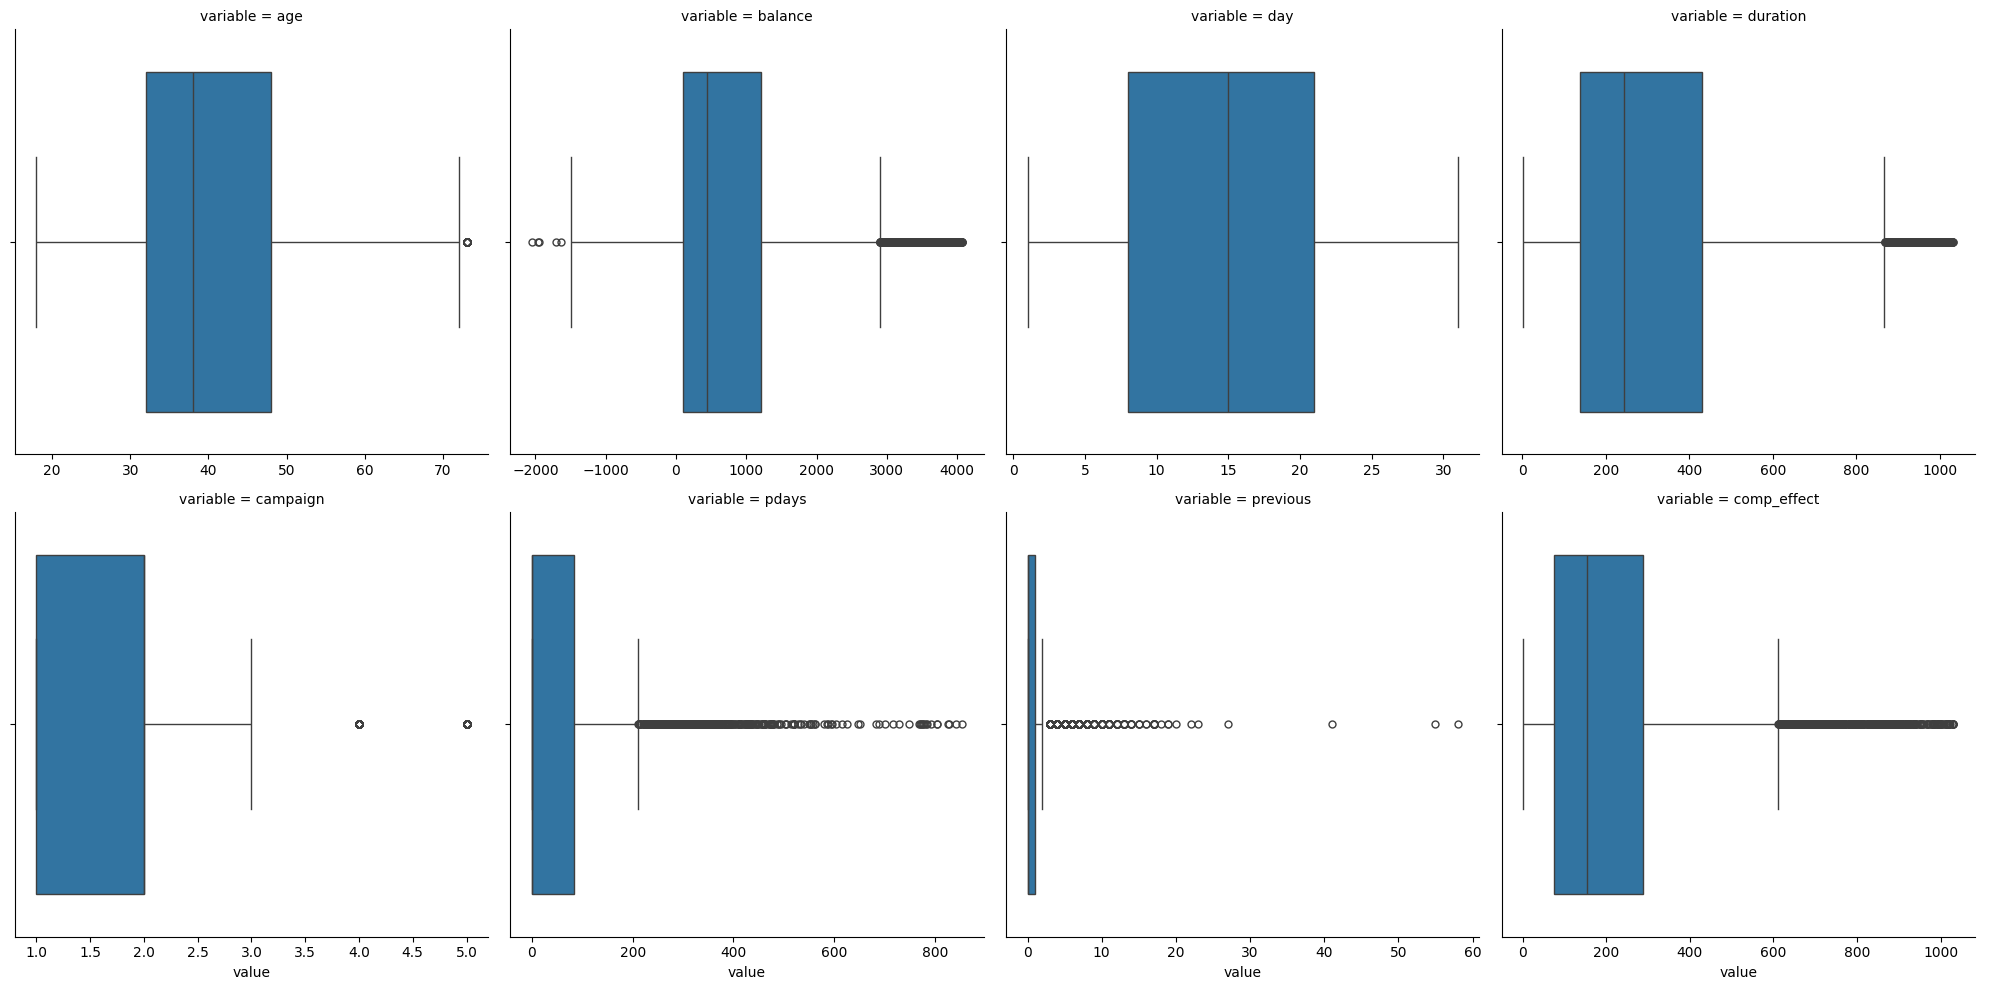

In [26]:
melted_df = df_num.melt(value_vars=df_num.select_dtypes(include=['int', 'float']).columns)

fig = sns.catplot(data=melted_df,
            x='value',
            col='variable',
            kind='box',
            col_wrap=4,
            sharex=False, sharey=False)

plt.show()

У дерев рішень нема потреби в нормальному розподілі й стандартизації даних - тому я омину ці кроки.

In [27]:
for i in df_num.columns:
    del df[i]
    df_num[i] = df_num[i].astype('float16')

In [28]:
df_num.head()

,age,balance,day,duration,campaign,pdays,previous,comp_effect
3,55.0,2476.0,5.0,579.0,1.0,0.0,0.0,579.0
4,54.0,184.0,5.0,673.0,2.0,0.0,0.0,336.5
5,42.0,0.0,5.0,562.0,2.0,0.0,0.0,281.0
7,60.0,545.0,6.0,1030.0,1.0,0.0,0.0,1030.0
8,37.0,1.0,6.0,608.0,1.0,0.0,0.0,608.0


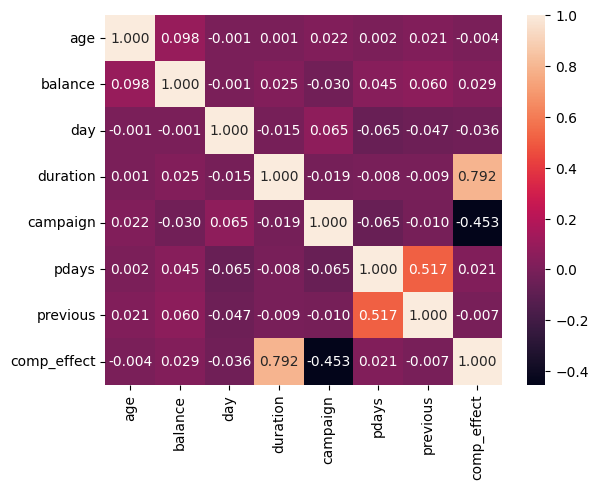

In [29]:
sns.heatmap(df_num.corr(), 
            annot=True,
            fmt='.3f')
plt.show()

Мультиколінеарність відсутня, хоча для нелінійних моделей вона проблем значних не завдає.

## New_df and categories feature engineering

In [30]:
# Сттворюю категорію сезональності
season_categories = ["spring", "summer", "autumn", "winter"]

spring_months = "mar|apr|may"
summer_months = "jun|jul|aug"
autumn_months = "sep|oct|nov"
winter_months = "dec|jan|feb"

# Умови для кожного сезону
conditions = [
    (df["month"].str.contains(spring_months)),
    (df["month"].str.contains(summer_months)),
    (df["month"].str.contains(autumn_months)),
    (df["month"].str.contains(winter_months))
]

###
df["seasonality"] = np.select(conditions, 
    season_categories, 
    default="unknown_season")
df['seasonality'] = df['seasonality'].astype('category')

In [31]:
# Змінюю тип даних на категоріальний, аби менше споживало пам'яті
for i in df.columns:
    if df[i].dtype=='object':
        df[i] = df[i].astype('category')
    elif i!='balance' and df[i].dtype=='int64':
        df[i] = df[i].astype('int16')

df["month"] = df["month"].cat.reorder_categories(new_categories=['jan', 'feb', 'mar', 'apr',
                                                                  'may', 'jun', 'jul', 'aug',
                                                                  'sep', 'oct', 'nov', 'dec'],
                                                  ordered=True)

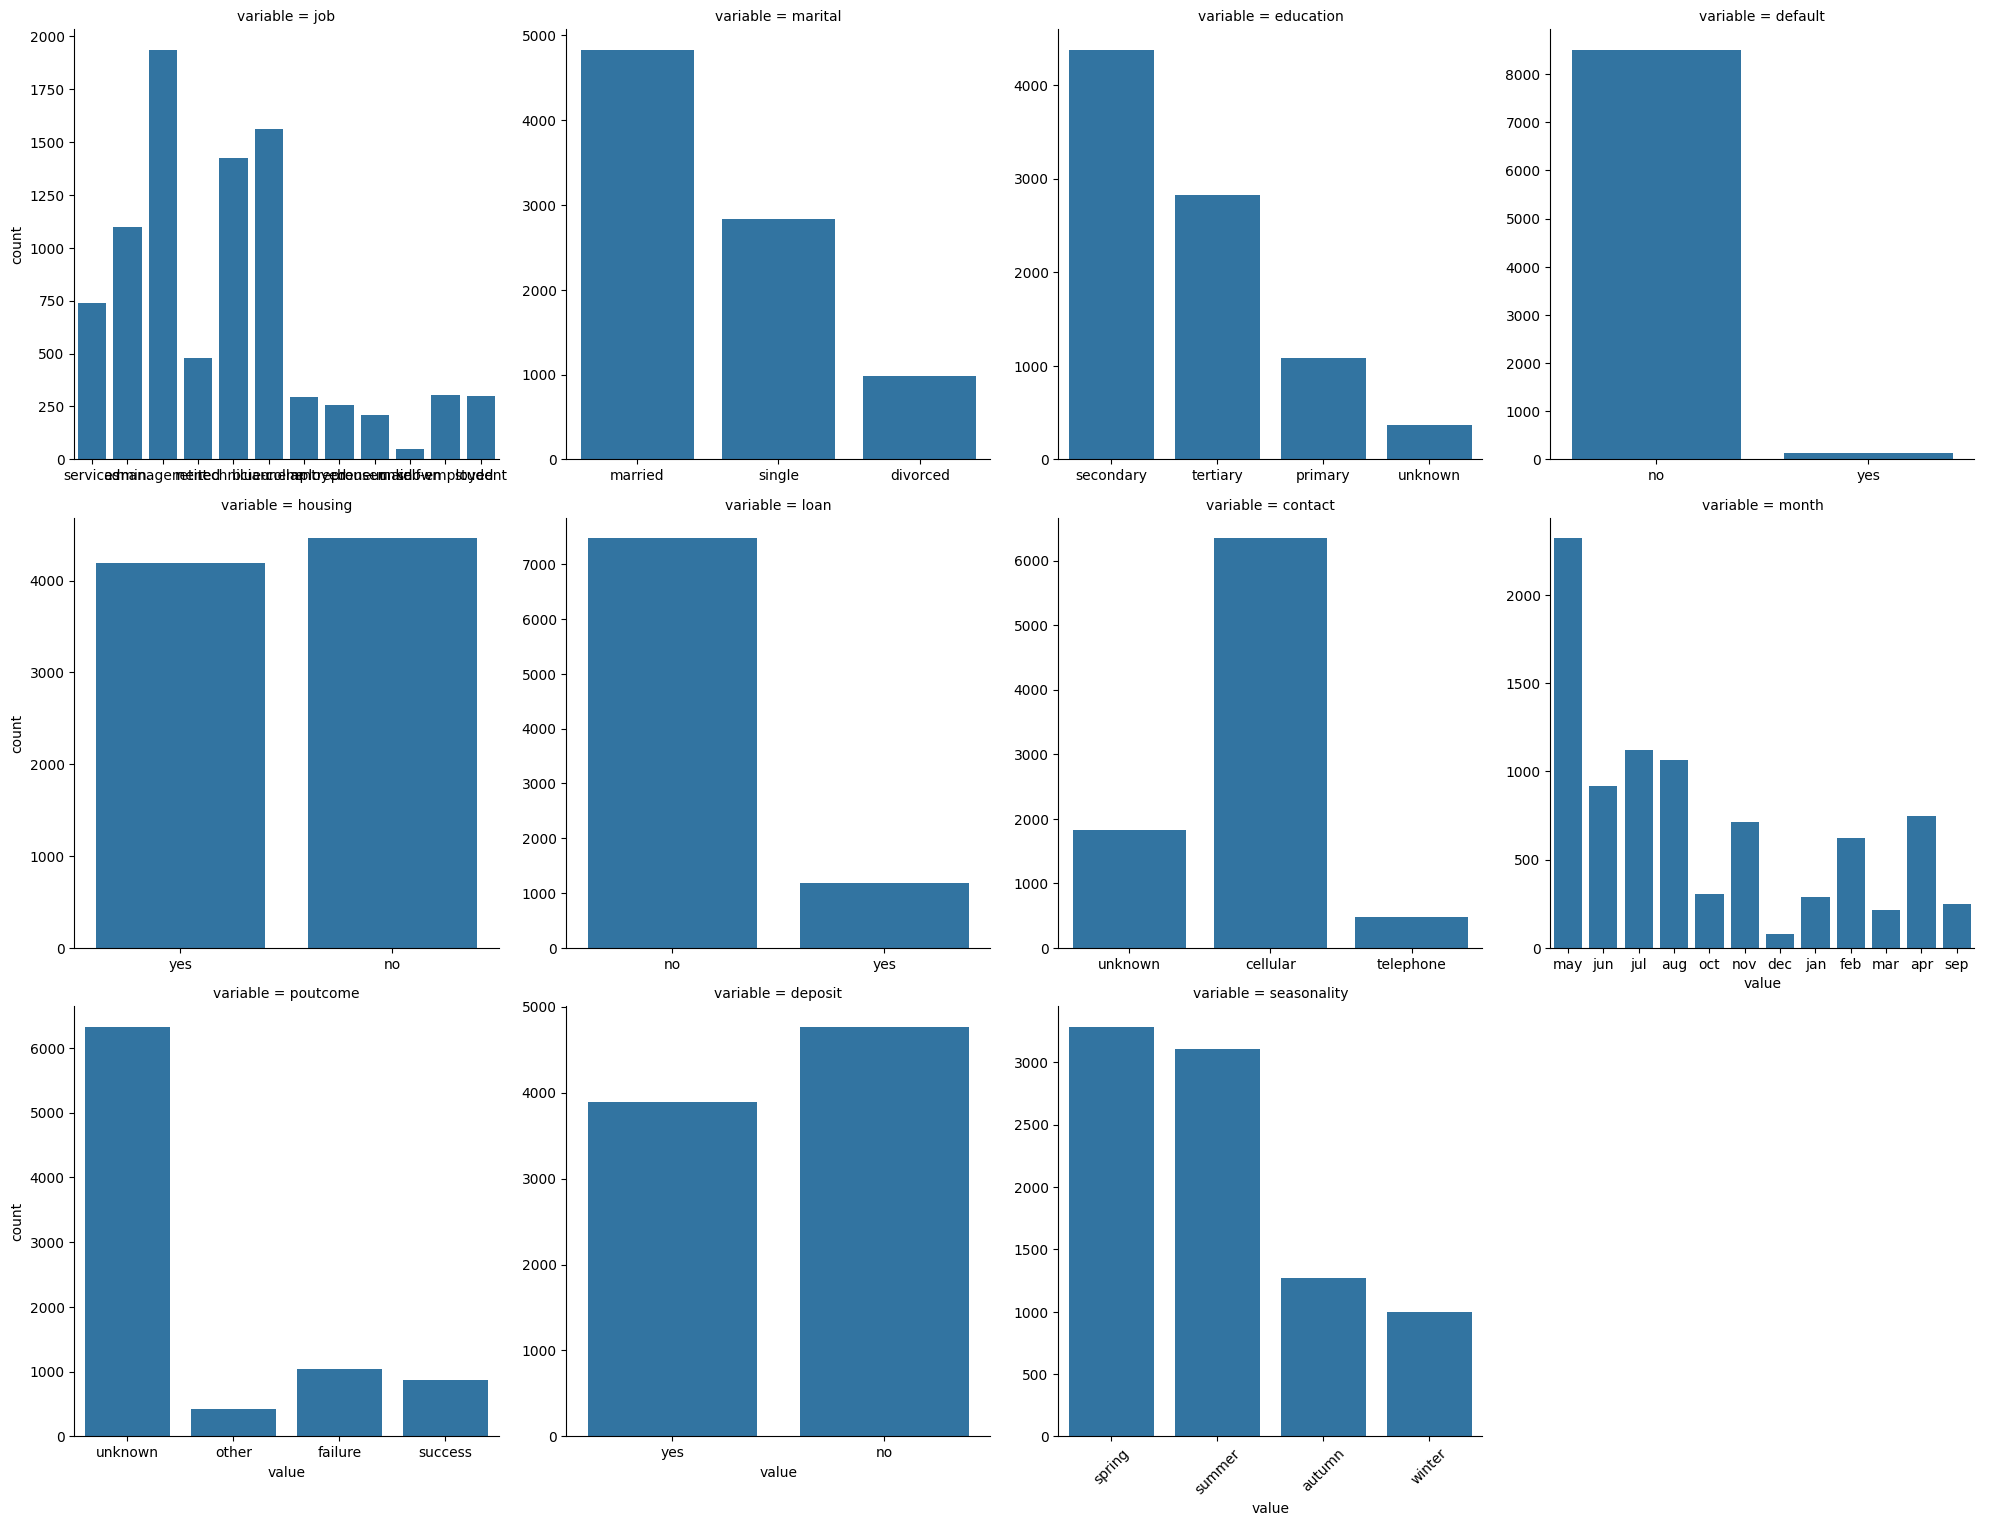

In [32]:
# Розподіл кожної з категорій
melted_df = df.melt(value_vars=df.select_dtypes(include='category').columns)

g = sns.catplot(data=melted_df,
            x='value',
            col='variable',
            kind='count',
            col_wrap=4,
            sharex=False, sharey=False)


plt.xticks(rotation=45)
plt.savefig('catplot.png', 
            bbox_inches='tight',
            dpi=300)
plt.show()

In [33]:
# Новий датафрейм з оновленними даними
new_df = df_num.merge(df, 
                   left_index=True, 
                   right_index=True)

In [34]:
# Всі категорії переводжу у числовий формат
le = LabelEncoder()
ohe = OneHotEncoder(handle_unknown='ignore')

for i in new_df.select_dtypes('category'):
    if new_df[i].nunique() == 2:
        new_df[i] = LabelEncoder().fit_transform(new_df[i]).astype('int8')
    else:
        ohote = pd.get_dummies(new_df[i], prefix=i)
        new_df = pd.concat([new_df, ohote], axis=1)
        del new_df[i]

df_new = new_df        
df_new.head()

,age,balance,day,duration,campaign,pdays,previous,comp_effect,default,housing,...,month_nov,month_dec,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,seasonality_autumn,seasonality_spring,seasonality_summer,seasonality_winter
3,55.0,2476.0,5.0,579.0,1.0,0.0,0.0,579.0,0,1,...,False,False,False,False,False,True,False,True,False,False
4,54.0,184.0,5.0,673.0,2.0,0.0,0.0,336.5,0,0,...,False,False,False,False,False,True,False,True,False,False
5,42.0,0.0,5.0,562.0,2.0,0.0,0.0,281.0,0,1,...,False,False,False,False,False,True,False,True,False,False
7,60.0,545.0,6.0,1030.0,1.0,0.0,0.0,1030.0,0,1,...,False,False,False,False,False,True,False,True,False,False
8,37.0,1.0,6.0,608.0,1.0,0.0,0.0,608.0,0,1,...,False,False,False,False,False,True,False,True,False,False


In [35]:
# Нова ознкак, яка показує загальну кулькість кредитів у клієнта (додаю один, щоб при перевірці фінансової стабільності не було 0, якщо в клієнта нема кредитів).
for i in ['default', 'housing', 'loan']:
    df_new[i] = df_new[i].astype('int8')

###
df_new['credit_overall'] = (df_new[['default', 'housing', 'loan']].sum(axis=1) + 1).astype('int8')
df_new.shape

(8652, 55)

In [36]:
# Співвідношення між балансом та кількістю кредитів 
###
df_new['fin_index'] = (df_new['balance'] / df_new['credit_overall']).astype('float32')

In [ ]:
df_new.head()
df_new.isna().sum()

## Train / Test split

In [37]:
X = df_new.drop('deposit', axis=1).values
y = df_new.deposit.astype('category').values
X_1 = df_new.drop('deposit', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    stratify=y,
                                                    test_size=0.3)

In [19]:
df_new.sample(5)

,age,balance,day,duration,campaign,pdays,previous,comp_effect,default,housing,...,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,seasonality_autumn,seasonality_spring,seasonality_summer,seasonality_winter,credit_overall,fin_index
540,39.0,0.0,22.0,864.0,4.0,0.0,0.0,216.0,0,0,...,False,False,False,True,False,False,True,False,1,0.0
845,53.0,25.0,22.0,528.0,2.0,0.0,0.0,264.0,0,0,...,False,False,False,True,False,False,True,False,1,25.0
4727,44.0,1697.0,4.0,150.0,2.0,0.0,0.0,75.0,0,1,...,False,False,False,True,False,False,True,False,2,848.5
2418,49.0,914.0,4.0,185.0,1.0,0.0,0.0,185.0,0,0,...,False,False,False,True,False,False,True,False,1,914.0
10042,59.0,374.0,29.0,272.0,2.0,0.0,0.0,136.0,0,0,...,False,False,False,True,False,False,True,False,1,374.0


# Cross-validation for choosing best models

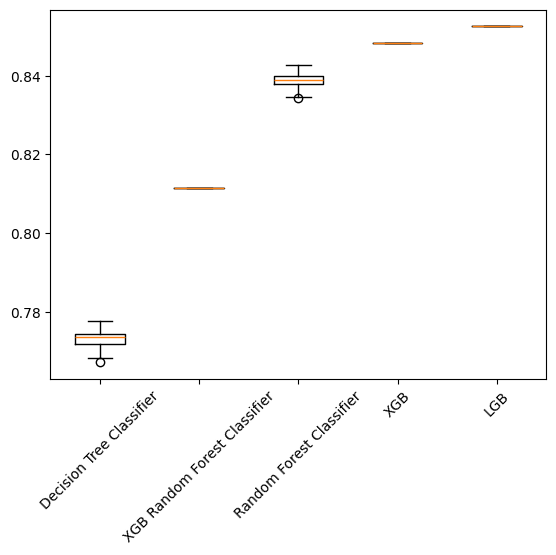

In [81]:
models = {'Decision Tree Classifier': DecisionTreeClassifier(),
          'XGB Random Forest Classifier': xgb.XGBRFClassifier(booster='gbtree'),
          'Random Forest Classifier': RandomForestClassifier(),
          'XGB': xgb.XGBClassifier(booster='gbtree', objective='reg:logistic'),
          'LGB': lgb.LGBMClassifier(objective='binary', boosting_type='gbdt', metric='binary_logloss')}


results = {}
for name, model in models.items():
    list = []
    for _ in range(100):
        kf = StratifiedKFold(n_splits=5,
                    shuffle=True,
                    random_state=42)
        score = cross_val_score(model,
                              X_train,
                              y_train,
                              cv=kf,
                              error_score='raise',
                              n_jobs=-1)
        list.append(np.mean(score))
    results[name] = list


plt.boxplot(results.values(), tick_labels=results.keys())
plt.xticks(rotation=45)
plt.savefig('cross.png', 
            bbox_inches='tight',
            dpi=300)
plt.show()

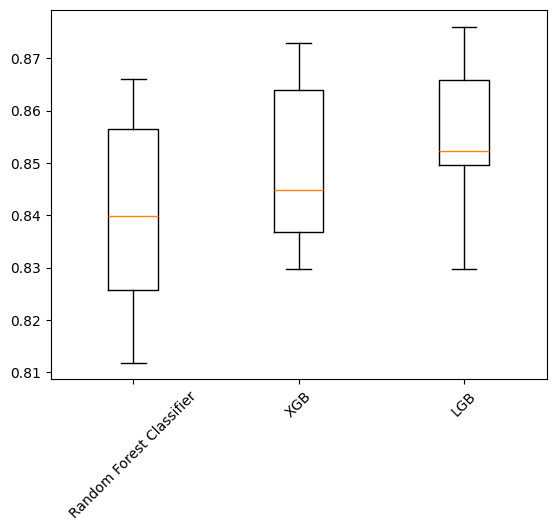

In [56]:
models = {'Random Forest Classifier': RandomForestClassifier(),
          'XGB': xgb.XGBClassifier(booster='gbtree', objective='reg:logistic'),
          'LGB': lgb.LGBMClassifier(objective='binary', boosting_type='gbdt', metric='binary_logloss')}

results = []
for model in models.values():
    kf = StratifiedKFold(n_splits=10,
                shuffle=True,
                random_state=42)
    score = cross_val_score(model,
                          X_train,
                          y_train,
                          cv=kf,
                          n_jobs=-1)
    results.append(score)


plt.boxplot(results, tick_labels=models.keys())
plt.xticks(rotation=45)
plt.show()

# MODELS

## LGBClassifier

In [109]:
def objective(trial):

    params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'metric': 'binary_logloss',
        'verbosity': -2,
        'n_jobs': -1,
        'random_state': 1,
        
        'lambda_l1': trial.suggest_float('lambda_l1', 0.01, 0.25, step=0.01),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.01, 0.25, step=0.01),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.051, step=0.001),
        
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        
        'subsample': trial.suggest_float('subsample', 0.8, 1, step=0.01),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100)
    }
  
    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    return accuracy

study_lgb = optuna.create_study(direction='maximize',
                                sampler=optuna.samplers.RandomSampler(seed=1))
study_lgb.optimize(objective, n_trials=2500)

[I 2024-05-20 15:31:02,233] A new study created in memory with name: no-name-d9bf9ae1-d14f-45f3-8f0e-2241a8b100c9
[I 2024-05-20 15:31:02,470] Trial 0 finished with value: 0.6178736517719569 and parameters: {'lambda_l1': 0.11, 'lambda_l2': 0.19, 'learning_rate': 0.001, 'max_depth': 18, 'n_estimators': 116, 'subsample': 0.81, 'num_leaves': 44, 'min_child_samples': 38}. Best is trial 0 with value: 0.6178736517719569.
[I 2024-05-20 15:31:02,613] Trial 1 finished with value: 0.8582434514637904 and parameters: {'lambda_l1': 0.09999999999999999, 'lambda_l2': 0.14, 'learning_rate': 0.022000000000000002, 'max_depth': 36, 'n_estimators': 142, 'subsample': 0.98, 'num_leaves': 23, 'min_child_samples': 69}. Best is trial 1 with value: 0.8582434514637904.
[I 2024-05-20 15:31:03,187] Trial 2 finished with value: 0.8543913713405239 and parameters: {'lambda_l1': 0.11, 'lambda_l2': 0.14, 'learning_rate': 0.008, 'max_depth': 14, 'n_estimators': 411, 'subsample': 1.0, 'num_leaves': 61, 'min_child_samples'

In [110]:
trial_lgb = study_lgb.best_trial
params_lgb = trial_lgb.params

print('Параметри найкращої моделі:', params_lgb)

Параметри найкращої моделі: {'lambda_l1': 0.13, 'lambda_l2': 0.01, 'learning_rate': 0.046, 'max_depth': 17, 'n_estimators': 272, 'subsample': 0.93, 'num_leaves': 20, 'min_child_samples': 15}


In [38]:
params_lgb_ = {'lambda_l1': 0.13, 'lambda_l2': 0.01, 'learning_rate': 0.046, 
               'max_depth': 17, 'n_estimators': 272, 'subsample': 0.93, 
               'num_leaves': 20, 'min_child_samples': 15}

model_lgb = lgb.LGBMClassifier(
    objective='binary',
    metric='binary_logloss',
    verbosity=-2,
    boosting_type='gbdt',
    n_jobs=-1,
    random_state=1,
    **params_lgb_) 
    # **params_lgb)                                 
                                 

model_lgb.fit(X_train, y_train)
print('Точність Light GB:', np.round(model_lgb.score(X_test, y_test), 4) * 100)

Точність Light GB: 87.17


C:\Users\ASUS-X515EP\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


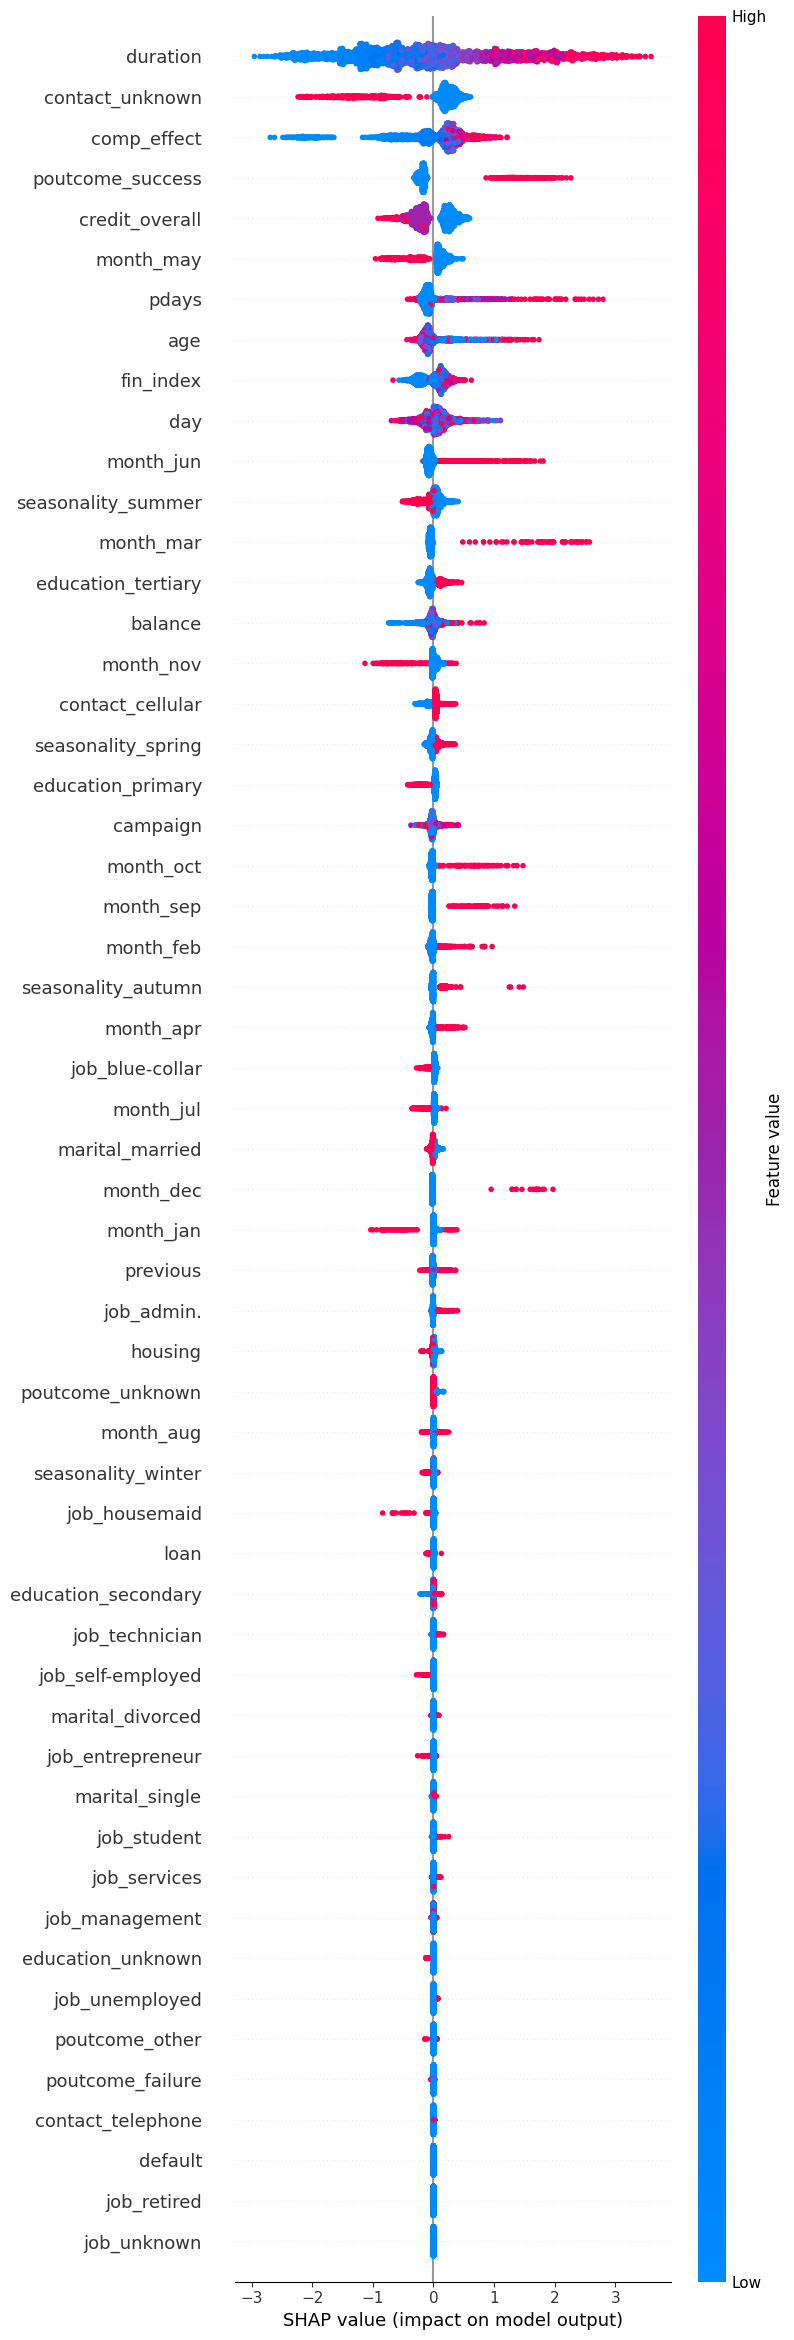

In [39]:
# Feature importance
shap_test = shap.TreeExplainer(model_lgb).shap_values(X_test)
shap.summary_plot(shap_test, X_test,
                  feature_names=X_1.columns,
                  max_display=len(X_1.columns))

## XGB RandomForestClassifier

In [113]:
def objective(trial):
    params = {
        'num_parallel_tree': trial.suggest_int('num_parallel_tree', 50, 400),
        'subsample': trial.suggest_float('subsample', 0.65, 0.85, step=0.01),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.65, 0.85, step=0.01),
        'max_depth': trial.suggest_int('max_depth', 3, 50),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'learning_rate': 1,  
    }

    model = xgb.XGBRFClassifier(random_state=61, 
                                booster='gbtree', 
                                **params)
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    return accuracy

study_rf_xgb = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=61))
study_rf_xgb.optimize(objective, n_trials=3000)

[I 2024-05-20 15:59:25,391] A new study created in memory with name: no-name-55eb73b9-8e0d-4976-a414-4ee36d2ce2a4
[I 2024-05-20 15:59:25,595] Trial 0 finished with value: 0.8285824345146379 and parameters: {'num_parallel_tree': 339, 'subsample': 0.68, 'colsample_bynode': 0.8300000000000001, 'max_depth': 26, 'min_child_weight': 20}. Best is trial 0 with value: 0.8285824345146379.
[I 2024-05-20 15:59:25,917] Trial 1 finished with value: 0.8412942989214176 and parameters: {'num_parallel_tree': 51, 'subsample': 0.8400000000000001, 'colsample_bynode': 0.78, 'max_depth': 17, 'min_child_weight': 7}. Best is trial 1 with value: 0.8412942989214176.
[I 2024-05-20 15:59:26,160] Trial 2 finished with value: 0.8351309707241911 and parameters: {'num_parallel_tree': 99, 'subsample': 0.75, 'colsample_bynode': 0.8300000000000001, 'max_depth': 24, 'min_child_weight': 10}. Best is trial 1 with value: 0.8412942989214176.
[I 2024-05-20 15:59:26,266] Trial 3 finished with value: 0.8089368258859785 and param

In [114]:
trial_rf_xgb = study_rf_xgb.best_trial
params_rf_xgb = trial_rf_xgb.params

print('Параметри найкращої моделі:', params_rf_xgb)

Параметри найкращої моделі: {'num_parallel_tree': 355, 'subsample': 0.65, 'colsample_bynode': 0.6900000000000001, 'max_depth': 29, 'min_child_weight': 1}


In [24]:
params_rf_xgb_ = {'num_parallel_tree': 355, 'subsample': 0.65, 'colsample_bynode': 0.6900000000000001, 'max_depth': 29, 'min_child_weight': 1}


model_rf_xgb = xgb.XGBRFClassifier(random_state=61,
                                 booster='gbtree', 
                                 **params_rf_xgb_) 

model_rf_xgb.fit(X_train, y_train)
print('Точність RandomForestClassifier:', np.round(model_rf_xgb.score(X_test, y_test), 3))

Точність RandomForestClassifier: 0.857


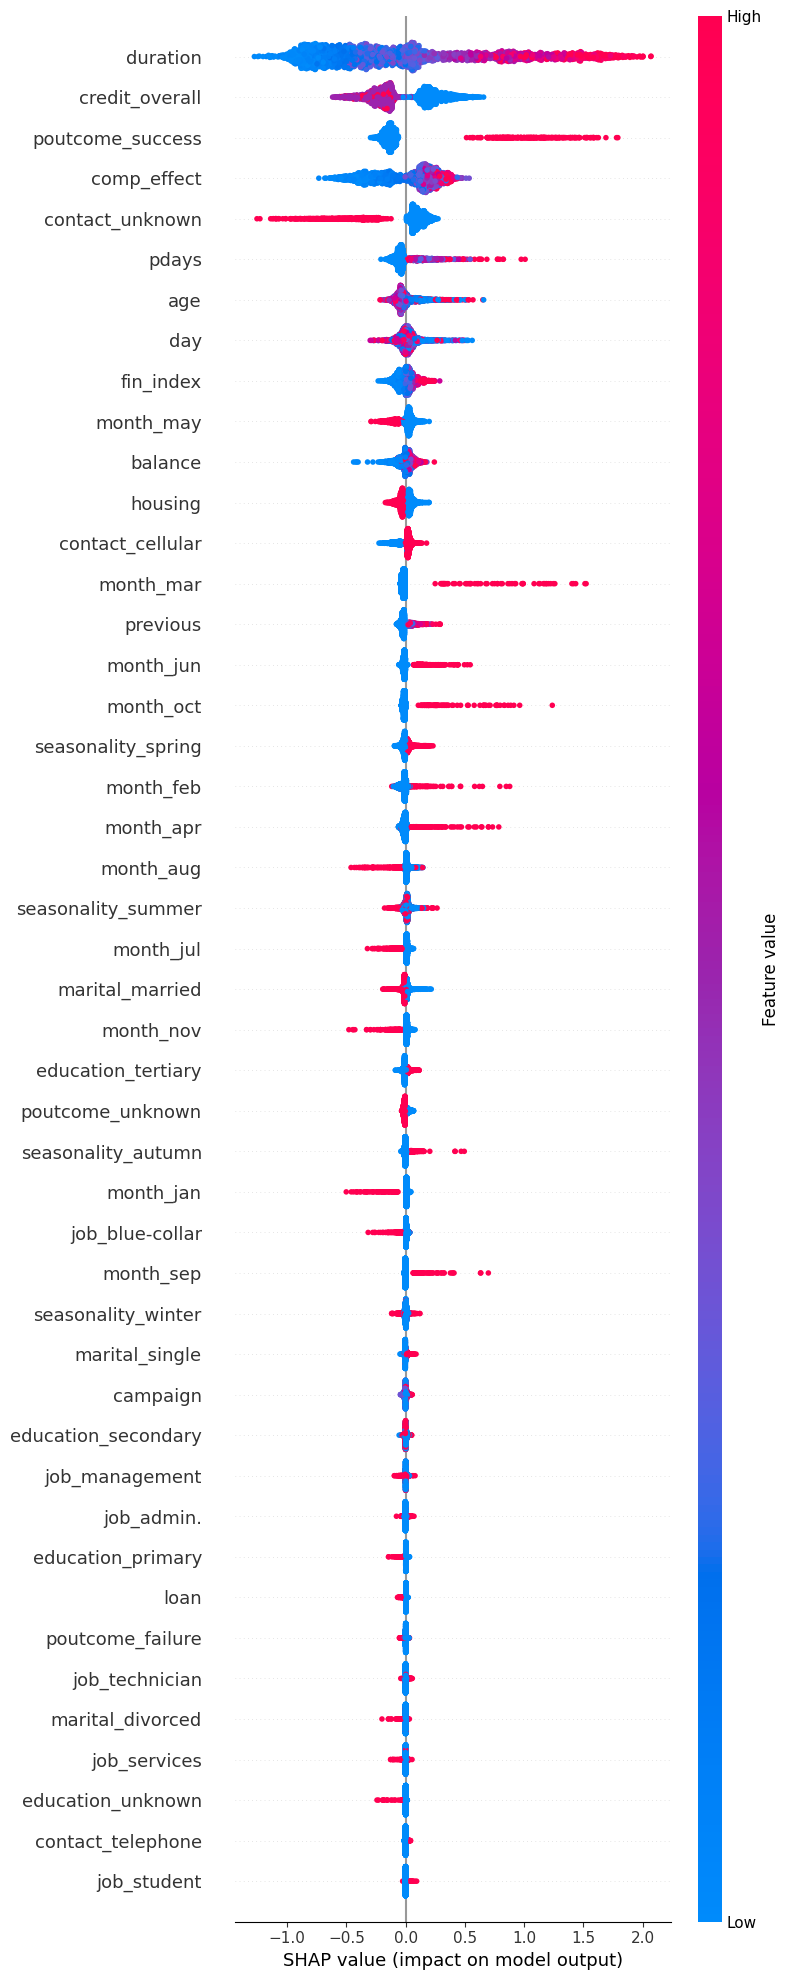

In [46]:
# Feature importance
shap_test = shap.TreeExplainer(model_rf_xgb).shap_values(X_test)
shap.summary_plot(shap_test, X_test,
                  feature_names=X_1.columns,
                  max_display=46)

## RandomForestClassifier

In [130]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 450),
        'max_depth': trial.suggest_int('max_depth', 3, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True]),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy'])
    }

    model = RandomForestClassifier(random_state=61,
                                   n_jobs=-1,
                                   **params)
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    return accuracy


study_rf = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=42))
study_rf.optimize(objective, n_trials=2000)

[I 2024-05-20 17:37:09,907] A new study created in memory with name: no-name-dc4e5588-c1b9-4f34-94fb-f1da0498f46e
[I 2024-05-20 17:37:10,332] Trial 0 finished with value: 0.8478428351309707 and parameters: {'n_estimators': 200, 'max_depth': 48, 'min_samples_split': 15, 'min_samples_leaf': 12, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8478428351309707.
[I 2024-05-20 17:37:10,903] Trial 1 finished with value: 0.8439907550077042 and parameters: {'n_estimators': 291, 'max_depth': 36, 'min_samples_split': 2, 'min_samples_leaf': 20, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8478428351309707.
[I 2024-05-20 17:37:11,316] Trial 2 finished with value: 0.8536209553158706 and parameters: {'n_estimators': 172, 'max_depth': 28, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 2 with value: 0.8536209553158706.


In [133]:
trial_rf = study_rf.best_trial
params_rf = trial_rf.params

print('Параметри найкращої моделі:', params_rf)

Параметри найкращої моделі: {'n_estimators': 237, 'max_depth': 32, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'entropy'}


In [84]:
params_rf_ = {'n_estimators': 237, 'max_depth': 32, 'min_samples_split': 10, 
              'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'entropy'}


model_rf = RandomForestClassifier(n_jobs=-1,
                                 random_state=61,
                                 **params_rf_) 

model_rf.fit(X_train, y_train)
print('Точність RandomForestClassifier:', np.round(model_rf.score(X_test, y_test), 4) * 100)

Точність RandomForestClassifier: 86.59


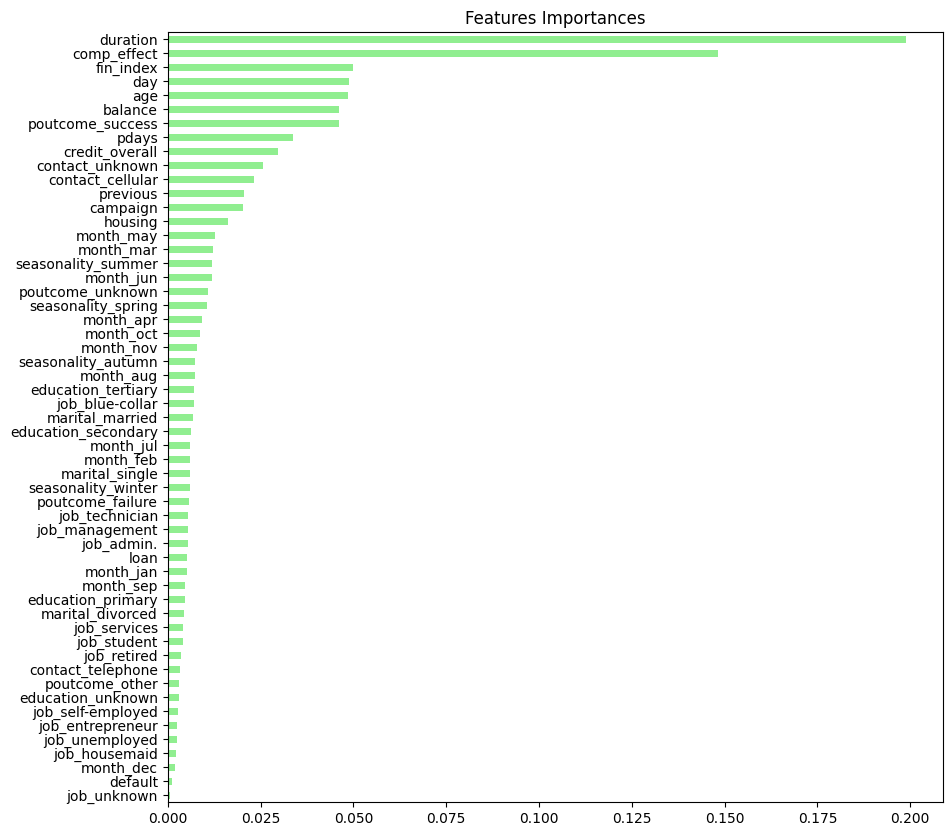

In [50]:
importances = pd.Series(data=model_rf.feature_importances_,
                        index=df_new.drop('deposit', axis=1).columns)

importances_sorted = importances.sort_values()

importances_sorted.plot(kind='barh',
        color='lightgreen',
        figsize=(10, 10))
plt.title('Features Importances')
plt.show()

## XGBClassifier

In [119]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int("n_estimators", 50, 500),
        'max_depth': trial.suggest_int("max_depth", 3, 50),
        'learning_rate': trial.suggest_float("learning_rate", 0.001, 0.051, step=0.001),
        'subsample': trial.suggest_float("subsample", 0.5, 1.0),
        'reg_lambda': trial.suggest_float('lambda', 0.01, 0.2, step=0.01),
        'alpha': trial.suggest_float('alpha', 0.01, 0.2, step=0.01),
        
        'use_label_encoder': False,
        'random_state': 42,
        'n_jobs': -1
    }

    model = xgb.XGBClassifier(
        booster='gbtree',
        objective='binary:logistic',
        **params
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

study_xgb = optuna.create_study(direction='maximize',
                                sampler=optuna.samplers.RandomSampler(seed=42))
study_xgb.optimize(objective, n_trials=1500)

[I 2024-05-20 16:29:14,393] A new study created in memory with name: no-name-161267e3-ad6c-44ce-a16c-7714825f2d55
[I 2024-05-20 16:29:15,735] Trial 0 finished with value: 0.8555469953775039 and parameters: {'n_estimators': 218, 'max_depth': 48, 'learning_rate': 0.038, 'subsample': 0.7993292420985183, 'lambda': 0.04, 'alpha': 0.04}. Best is trial 0 with value: 0.8555469953775039.
[I 2024-05-20 16:29:16,476] Trial 1 finished with value: 0.8540061633281972 and parameters: {'n_estimators': 76, 'max_depth': 44, 'learning_rate': 0.031, 'subsample': 0.8540362888980227, 'lambda': 0.01, 'alpha': 0.2}. Best is trial 0 with value: 0.8555469953775039.
[I 2024-05-20 16:29:18,201] Trial 2 finished with value: 0.863251155624037 and parameters: {'n_estimators': 425, 'max_depth': 13, 'learning_rate': 0.010000000000000002, 'subsample': 0.5917022549267169, 'lambda': 0.06999999999999999, 'alpha': 0.11}. Best is trial 2 with value: 0.863251155624037.
[I 2024-05-20 16:29:19,301] Trial 3 finished with value:

In [120]:
trial_xgb = study_xgb.best_trial
params_xgb = trial_xgb.params

print('Параметри найкращої моделі:', params_xgb)

Параметри найкращої моделі: {'n_estimators': 405, 'max_depth': 4, 'learning_rate': 0.05, 'subsample': 0.7632974712948947, 'lambda': 0.06999999999999999, 'alpha': 0.08}


In [91]:
params_xgb_ = {'n_estimators': 405, 'max_depth': 4, 'learning_rate': 0.05, 
               'subsample': 0.7632974712948947, 'lambda': 0.06999999999999999, 'alpha': 0.08}


model_xgb = xgb.XGBClassifier(n_jobs=-1,
                                 random_state=42,
                                 **params_xgb_) 
                                 # **params_xgb)

model_xgb.fit(X_train, y_train)
print('Точність RandomForestClassifier:', np.round(model_xgb.score(X_test, y_test), 4) * 100)

Точність RandomForestClassifier: 86.94


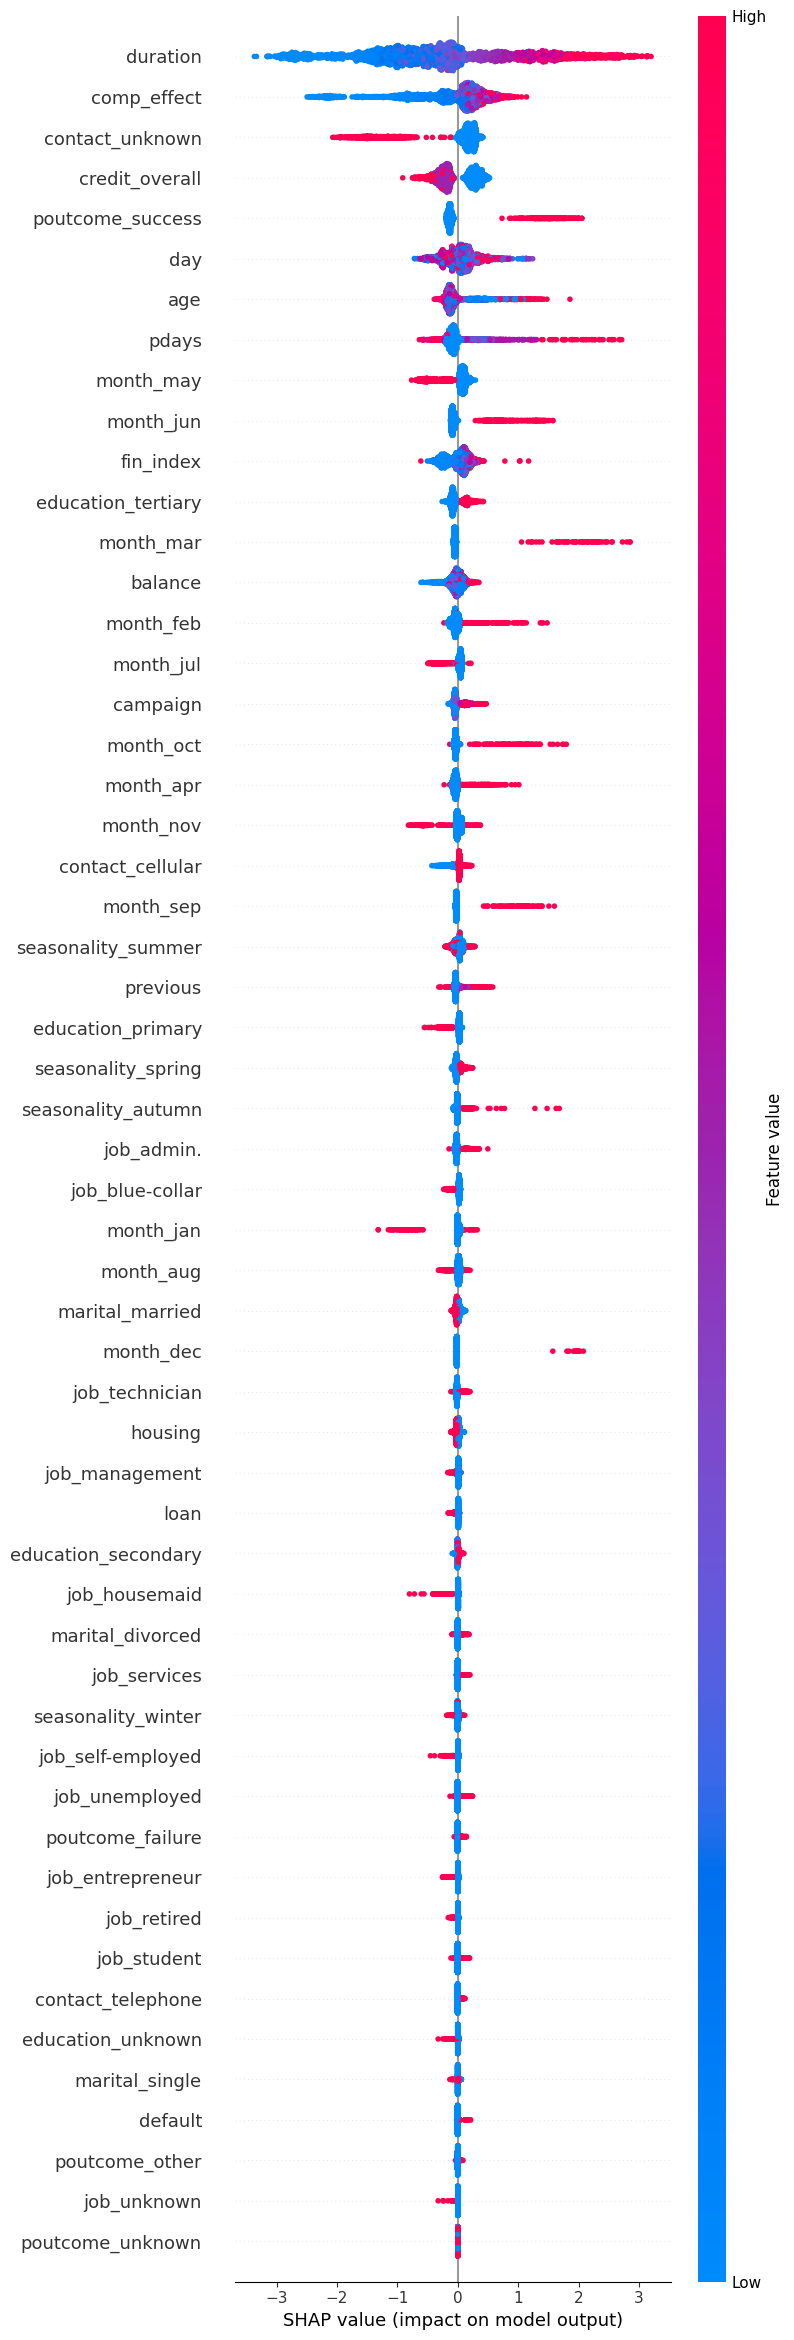

In [51]:
# Feature importance
explainer = shap.Explainer(model_xgb)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, 
                  X_test, 
                  feature_names=X_1.columns, 
                  max_display=len(X_1.columns))

In [ ]:
# Фактори, які можна пояснити
fact = pd.DataFrame(df_new[['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous',
                           'comp_effect', 'default', 'housing', 'loan', 'deposit', 'job_admin.',
                           'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
                           'job_management', 'job_retired', 'job_self-employed', 'job_services',
                           'job_student', 'job_technician', 'job_unemployed',
                           'education_primary', 'education_secondary', 'education_tertiary',
                           'contact_cellular', 'contact_telephone', 'contact_unknown', 
                           'month_jan', 'month_feb', 'month_mar', 'month_apr',
                           'month_may', 'month_jun', 'month_jul', 'month_aug', 'month_sep',
                           'month_oct', 'month_nov', 'month_dec', 'poutcome_failure',
                           'poutcome_success', 'seasonality_autumn', 'seasonality_spring', 
                           'seasonality_summer', 'seasonality_winter', 'credit_overall', 'fin_index']]).columns
fact

# Ensemble (final model)

In [92]:
classifiers = [('Bagging Classifier', model_rf),
               ('XGB', model_xgb),
               ('LGB', model_lgb)]

In [93]:
vc = VotingClassifier(estimators = classifiers)

vc.fit(X_train, y_train)
y_pred = vc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print('Voting Classifier: {:.4f}'.format(accuracy))

Voting Classifier: 0.8725


In [94]:
vc.fit(X_train, y_train)
y_pred = vc.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88      1430
           1       0.84      0.88      0.86      1166

    accuracy                           0.87      2596
   macro avg       0.87      0.87      0.87      2596
weighted avg       0.87      0.87      0.87      2596

[[1237  193]
 [ 138 1028]]
